# Кредитный скоринг

In [214]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

%matplotlib inline

In [215]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Choosing_Features")

<Experiment: artifact_location='/Users/nikitaefremov/Documents/DATA_SCIENCE/Credit_Scoring/notebooks/mlruns/4', creation_time=1713196089407, experiment_id='4', last_update_time=1713196089407, lifecycle_stage='active', name='Choosing_Features', tags={}>

____

In [216]:
df = pd.read_excel('../data/text_data_model.xlsx')

## EDA

In [217]:
df.describe(include='object')

,id,x3,x4,x5,x6,x11
count,2000,1987,2000,2000,34,2000
unique,2000,6,11,2000,34,127
top,7ED6CC5B-6628-4873-9D4C-33455B29CC4C,Android,UMID,*******ynordemaala1985@gmail.com,+6390627*****,"[{""id"": ""E115"", ""name"": ""Domain is a free prov..."
freq,1,1783,491,1,1,810


In [218]:
df.describe(include='number')

,x1,x2,x7,x8,x9,x10,y
count,2000.000000,1976.000000,1953.000000,1943.000000,1982.000000,1943.000000,2000.000000
mean,34.251812,22141.979757,0.292883,0.854864,0.838042,0.316006,0.352000
std,8.953549,22189.029628,0.455202,0.352329,0.368505,0.465035,0.477713
min,22.015058,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.338125,13000.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,32.243669,18500.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,39.380561,25000.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,68.553046,400000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### TODO:

Категориальные: \
id - убрать \
x3 - можно OHE, всего 6 значений \
x4 - 11 значений, можно попробовать либо OHE, либо OTE \
x5 - email, убрать \
x6 - очень мало значений, всего 34 номера. Либо убрать, либо попробовать сделать бинарную колонку, есть номер или нет \
x11 - много уникальных значений - 127. Распарсить JSON, посмотреть что есть важного

Числовые: \
x1 - нет пропусков \
x2 - похоже на доход, есть немного пропусков \
x7 - бинарная колонка, 47 пропущенных значений \
x8 - бинарная колонка, 57 пропущенных значений \
x9 - бинарная колонка, 18 пропущенных значений \
x10 - бинарная колонка, 57 пропущенных значений \
y - таргет, пропущенных нет 

Дата: \
dt - дата, можно извлечь год, месяц, день недели

### Корреляция признаков между собой

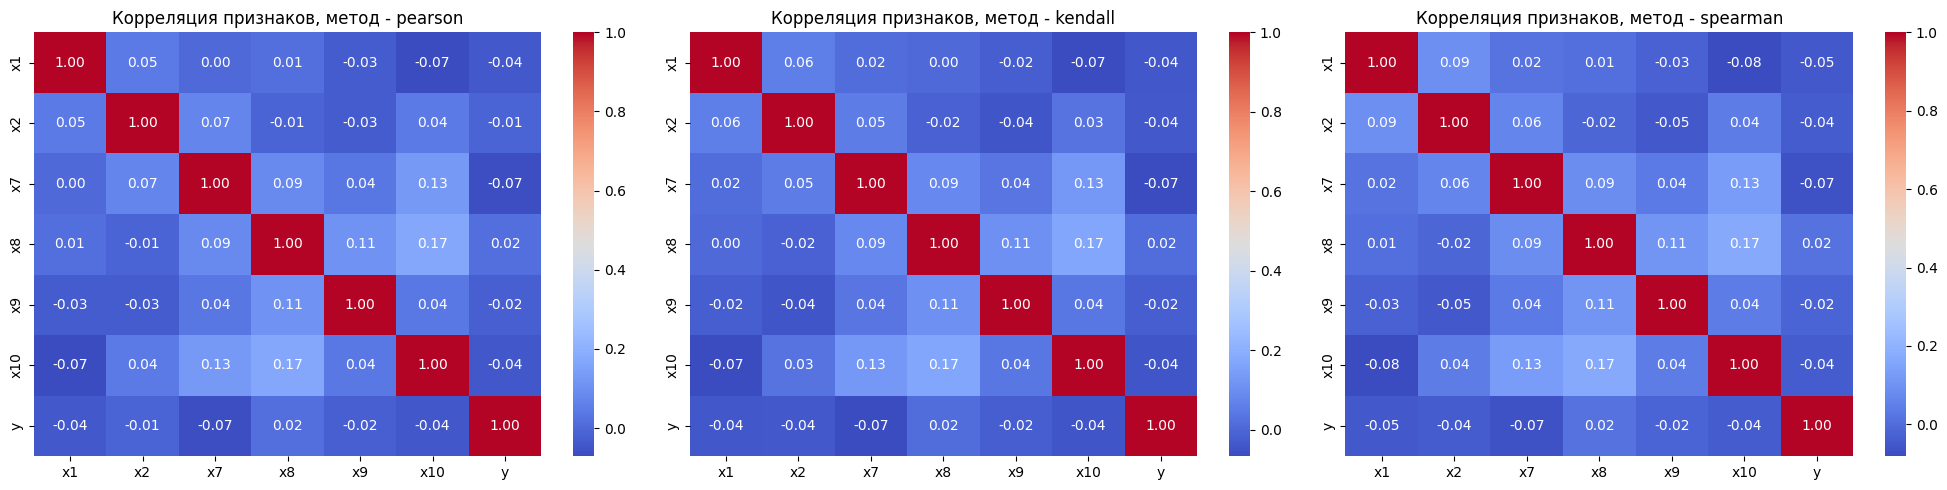

In [219]:
# Используем все три метода корреляции, в случае, если между признаками есть не только линейная зависимость
methods = ['pearson', 'kendall', 'spearman']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, method in enumerate(methods):
    corr_matrix = df[df.describe(include='number').columns].corr(method=method)
    sns.heatmap(corr_matrix, ax=axes[idx], annot=True, fmt=".2f", cmap='coolwarm')
    axes[idx].set_title(f'Корреляция признаков, метод - {method}')


plt.tight_layout() 
plt.show()

Значимой корреляции между признаками нет

In [220]:
df['y'].value_counts()

y
0    1296
1     704
Name: count, dtype: int64

Присутствует несильный дисбаланс классов

____

## Feature Engineering

In [221]:
# Удаляем колонку с индексом, колонку с почтой и колонку с большим количеством пропущенных значений
df = df.drop(['id', 'x5', 'x6'], axis=1)

In [222]:
# Выделяем из даты месяц и день недели
df['month'] = df['dt'].dt.month
df['day_of_week'] = df['dt'].dt.day_of_week

df = df.drop('dt', axis=1)

In [223]:
# Заполняем пропущенные значения в x2 средним значением
# TODO: Попробовать моду, медиану

df['x2'] = df['x2'].fillna(df.x2.median())

### Выбросы

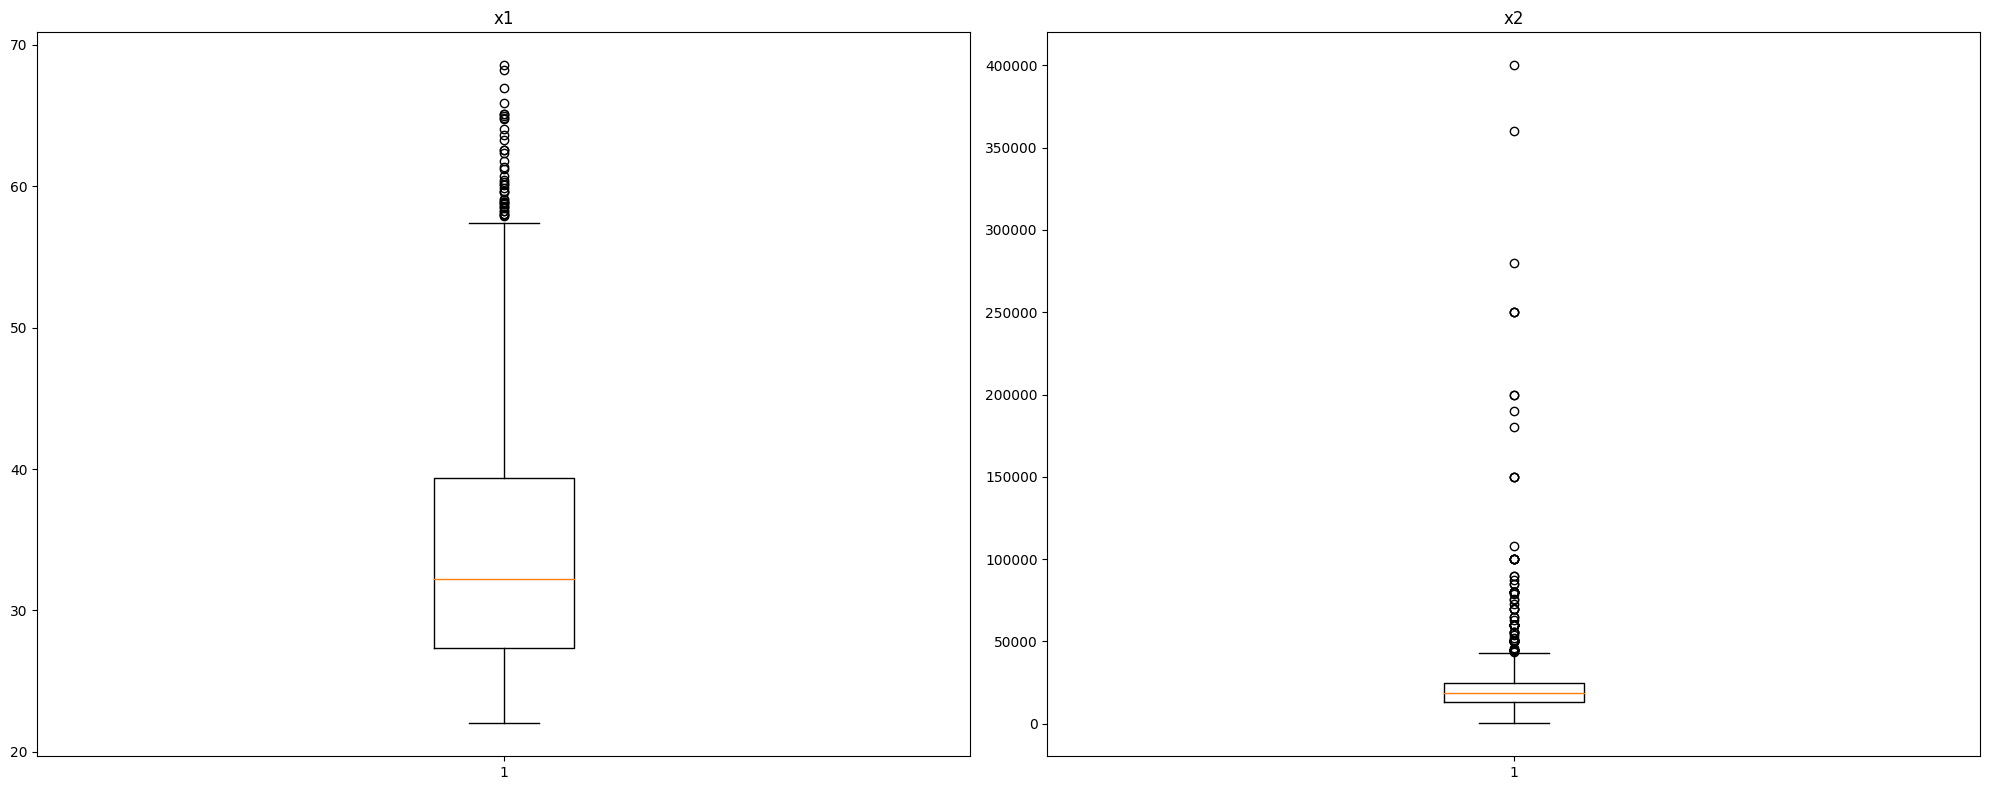

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

num_cols = ['x1', 'x2']
for idx, col in enumerate(num_cols):
    axes[idx].boxplot(df[col]) 
    axes[idx].set_title(f'{col}')

plt.tight_layout()
plt.show()    

В колонке x1 нет значительных выбросов. \
Удалим строки, где значение признака x2 > 200000 для улучшения точности модели

In [225]:
df = df[df['x2'] < 200000]

In [226]:
# Заполним пропущенные значения в бинарных колонках модой и приведем к типу int

cols = ['x7', 'x8', 'x9', 'x10']

for col in cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value).astype(int)

In [227]:
# Заполняем пропущенные значения в категориальных колонках модой
cat_cols = ['x3', 'x4']

for col in cat_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

In [228]:
# Проверяем, остались ли пропущенные значения
df.isna().sum()

x1             0
x2             0
x3             0
x4             0
x7             0
x8             0
x9             0
x10            0
x11            0
y              0
month          0
day_of_week    0
dtype: int64

#### Извлечение признаков из JSON

In [229]:
def safe_json_loads(s):
    try:
        return json.loads(s)
    except ValueError:
        return None  # или можно вернуть пустой список, если это предпочтительнее

df['x11'] = df['x11'].apply(safe_json_loads)

In [230]:
def calculate_score_stats(dicts):
    scores = [d.get('score') for d in dicts if 'score' in d]  # извлекаем все 'score'
    if not scores:  # проверяем, есть ли вообще 'score' для обработки
        return {'total_score': None, 'max_score': None, 'min_score': None}
    total_score = sum(scores)
    max_score = max(scores)
    min_score = min(scores)
    mean_score = sum(scores) / len(scores)
    return {'total_score': total_score, 'max_score': max_score, 'min_score': min_score, 'mean_score': mean_score}

In [231]:
new_features_df = pd.DataFrame()

In [232]:
new_features_df[['total_score', 'max_score', 'min_score', 'mean_score']] = df['x11'].apply(lambda x: pd.Series(calculate_score_stats(x)))

In [233]:
new_features_df.head()

,total_score,max_score,min_score,mean_score
0,1.0,1.0,0.0,0.5
1,1.0,1.0,0.0,0.5
2,1.0,1.0,0.0,0.5
3,1.0,1.0,0.0,0.5
4,3.0,2.0,0.0,1.0


In [234]:
df = df.drop('x11', axis=1)
df = pd.concat([df, new_features_df], axis=1)

#### Корреляция новых признаков между собой и таргетной переменной

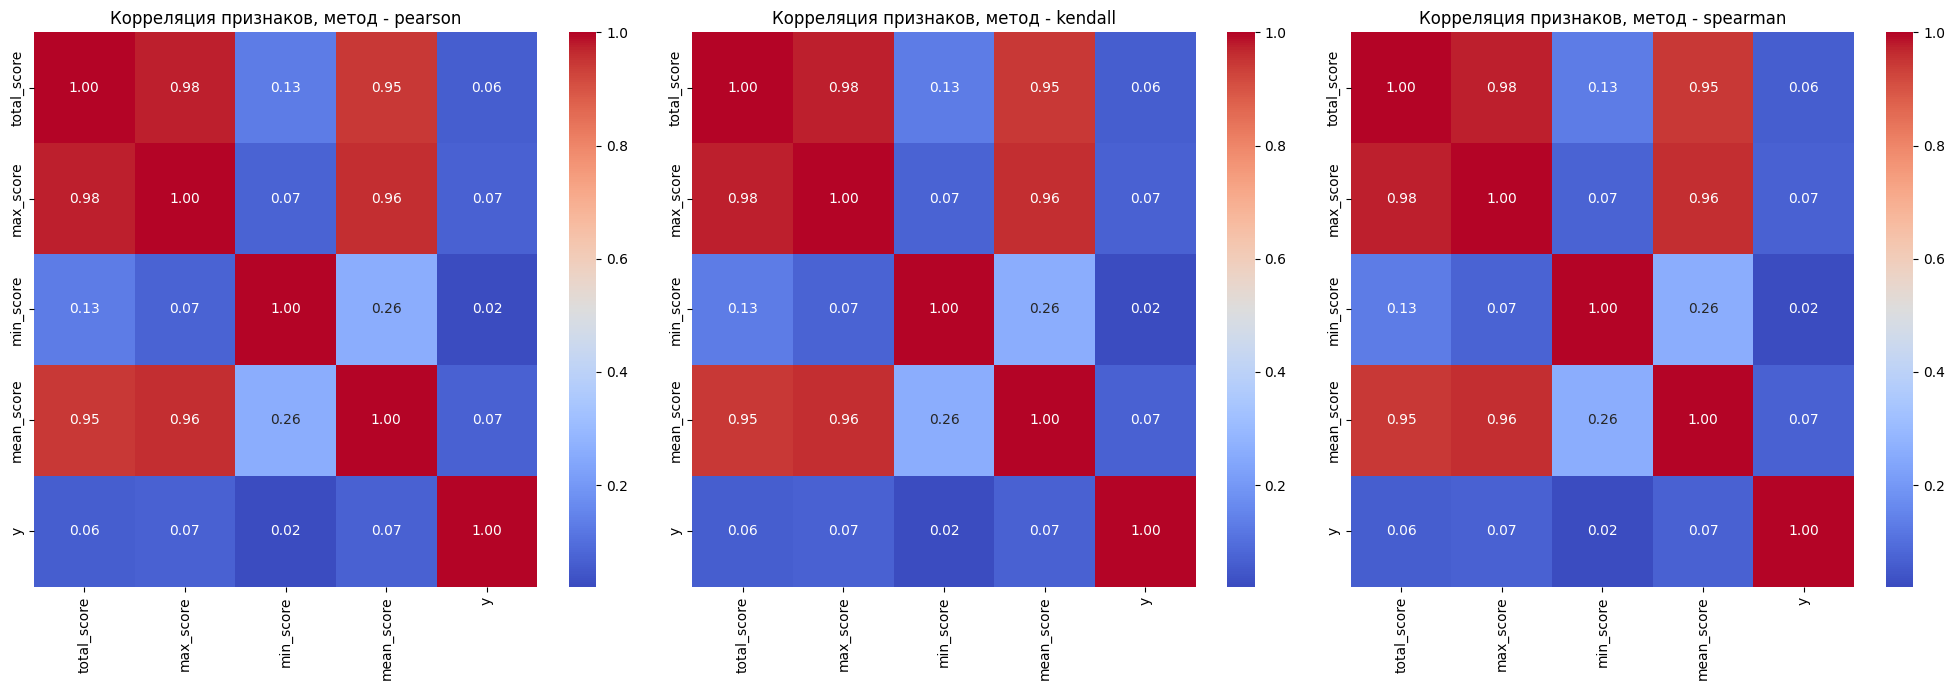

In [235]:
methods = ['pearson', 'kendall', 'spearman']

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, method in enumerate(methods):
    score_corr_matrix = df[['total_score', 'max_score', 'min_score', 'mean_score', 'y']].corr()
    sns.heatmap(score_corr_matrix, ax=axes[idx], annot=True, fmt=".2f", cmap='coolwarm')
    axes[idx].set_title(f'Корреляция признаков, метод - {method}')


plt.tight_layout() 
plt.show()

Нет явной корреляции признаков с таргетной переменной, но есть сильная корреляция между собой.

Для обучения модели будем использовать max_score и min_score

In [236]:
df.drop(['total_score', 'mean_score'], axis=1, inplace=True)

#### One Hot Encoding

In [237]:
# Скопируем датафрейм до OHE, для использования пакетной обработки категориальных признаков Catboost
df_for_cat = df.copy()

In [238]:
ohe_cols = ['x3', 'x4']

In [239]:
df = pd.get_dummies(df, columns=ohe_cols, dtype=int)

____

## Scaler

In [240]:
scaler = StandardScaler()

In [241]:
numerical_features_df = [i for i in df.describe(include='number').columns]

numerical_features_df_cf = [i for i in df_for_cat.describe(include='number')]

In [242]:
numerical_features_df.remove('y')
numerical_features_df_cf.remove('y')

In [243]:
df[numerical_features_df] = scaler.fit_transform(df[numerical_features_df])
df_for_cat[numerical_features_df_cf] = scaler.fit_transform(df_for_cat[numerical_features_df_cf])

___

In [244]:
df.head()

,x1,x2,x7,x8,x9,x10,y,month,day_of_week,max_score,...,x4_7,x4_18,x4_20,x4_21,x4_Driver license ID,x4_PRC,x4_Passport,x4_SSS,x4_TIN,x4_UMID
0,0.306617,0.198673,1.581417,0.405255,0.437479,1.503406,0,0.723948,-1.014434,-0.373272,...,-0.265315,-0.050163,-0.119401,-0.174707,2.007561,-0.166924,-0.3171,-0.239426,-0.411947,-0.569621
1,-0.778712,-0.347062,-0.632344,0.405255,0.437479,-0.665156,0,0.723948,-1.014434,-0.373272,...,-0.265315,-0.050163,-0.119401,-0.174707,2.007561,-0.166924,-0.3171,-0.239426,-0.411947,-0.569621
2,-0.797361,0.266890,-0.632344,0.405255,0.437479,1.503406,1,0.723948,-0.290669,-0.373272,...,-0.265315,-0.050163,-0.119401,-0.174707,-0.498117,-0.166924,-0.3171,-0.239426,2.427495,-0.569621
3,-0.316759,0.607974,-0.632344,0.405255,0.437479,-0.665156,1,0.723948,-0.290669,-0.373272,...,-0.265315,-0.050163,-0.119401,-0.174707,-0.498117,-0.166924,-0.3171,-0.239426,-0.411947,1.755553
4,0.128378,0.607974,1.581417,0.405255,-2.285826,-0.665156,1,0.723948,-1.014434,0.015822,...,-0.265315,-0.050163,-0.119401,-0.174707,-0.498117,-0.166924,-0.3171,-0.239426,-0.411947,-0.569621


In [245]:
df_for_cat.head()

,x1,x2,x3,x4,x7,x8,x9,x10,y,month,day_of_week,max_score,min_score
0,0.306617,0.198673,Android,Driver license ID,1.581417,0.405255,0.437479,1.503406,0,0.723948,-1.014434,-0.373272,-0.212474
1,-0.778712,-0.347062,Android,Driver license ID,-0.632344,0.405255,0.437479,-0.665156,0,0.723948,-1.014434,-0.373272,-0.212474
2,-0.797361,0.266890,Android,TIN,-0.632344,0.405255,0.437479,1.503406,1,0.723948,-0.290669,-0.373272,-0.212474
3,-0.316759,0.607974,Android,UMID,-0.632344,0.405255,0.437479,-0.665156,1,0.723948,-0.290669,-0.373272,-0.212474
4,0.128378,0.607974,Android,4,1.581417,0.405255,-2.285826,-0.665156,1,0.723948,-1.014434,0.015822,-0.212474


___

## Choose Features

In [246]:
df.columns

Index(['x1', 'x2', 'x7', 'x8', 'x9', 'x10', 'y', 'month', 'day_of_week',
       'max_score', 'min_score', 'x3_Android', 'x3_Chrome OS', 'x3_OS X',
       'x3_Windows 10', 'x3_Windows 7', 'x3_iOS', 'x4_4', 'x4_7', 'x4_18',
       'x4_20', 'x4_21', 'x4_Driver license ID', 'x4_PRC', 'x4_Passport',
       'x4_SSS', 'x4_TIN', 'x4_UMID'],
      dtype='object')

In [247]:
features = ['x1', 'x2', 'x7', 'x8', 'x9', 'x10', 'month', 'day_of_week',
            'x3_Android', 'x3_Chrome OS', 'x3_OS X',
           'x3_Windows 10', 'x3_Windows 7', 'x3_iOS', 'x4_4', 'x4_7', 'x4_18',
           'x4_20', 'x4_21', 'x4_Driver license ID', 'x4_PRC', 'x4_Passport',
           'x4_SSS', 'x4_TIN', 'x4_UMID', 'y']

In [248]:
df = df[features]

## Train test split

In [249]:
X = df.drop('y', axis=1)
y = df['y']

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

In [251]:
with mlflow.start_run():

    # Инициализируем параметры
    params = {
        'max_iter': 1000,
        'penalty': 'l1',
        'solver': 'liblinear'
    }

    # Логируем название модели и параметры
    mlflow.set_tag('model_name', 'Logistic_Regression')
    mlflow.log_params(params)

    # Обучаем модель
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Делаем предсказание
    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test, y_hat_test) 
    gini_test = 2 * roc_auc_test - 1

    # Логируем метрики и модель
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.sklearn.log_model(model, 'sk_models')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Random Forest

In [252]:
with mlflow.start_run():

    # Инициализируем параметры
    params = {
        'n_estimators': 100,
        'max_depth': 100,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'criterion': 'gini'
    }

    # Логируем название модели и параметры
    mlflow.set_tag('model_name', 'RandomForestClassifier')
    mlflow.log_params(params)

    # Обучаем модель
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Делаем предсказание
    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test, y_hat_test)
    gini_test = 2 * roc_auc_test - 1 

    # Логируем метрики и модель
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.sklearn.log_model(model, 'RF_models')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## CatBoost

In [79]:
with mlflow.start_run():

    # Инициализируем параметры
    params = {
        'iterations': 1000,
        'learning_rate': 0.01,
        'depth': 5,
        'cat_features': None,
        'verbose': 0
    }

    # Логируем название модели и параметры
    mlflow.set_tag('model_name', 'CatBoostClassifier')
    mlflow.log_params(params)

    # Обучаем модель
    # model = CatBoostClassifier(verbose=0)
    model = CatBoostClassifier()
    model.fit(X_train, y_train)

    # Делаем предсказание
    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test, y_hat_test)
    gini_test = 2 * roc_auc_test - 1

    # Логируем метрики и модель
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.catboost.log_model(model, 'CB_models')

Learning rate set to 0.012568
0:	learn: 0.6919251	total: 58ms	remaining: 57.9s
1:	learn: 0.6907714	total: 58.7ms	remaining: 29.3s
2:	learn: 0.6896741	total: 59.4ms	remaining: 19.7s
3:	learn: 0.6885845	total: 60.2ms	remaining: 15s
4:	learn: 0.6874992	total: 60.9ms	remaining: 12.1s
5:	learn: 0.6864645	total: 61.5ms	remaining: 10.2s
6:	learn: 0.6854516	total: 62.3ms	remaining: 8.83s
7:	learn: 0.6844464	total: 63ms	remaining: 7.81s
8:	learn: 0.6834345	total: 63.7ms	remaining: 7.02s
9:	learn: 0.6824779	total: 64.3ms	remaining: 6.37s
10:	learn: 0.6815567	total: 64.9ms	remaining: 5.84s
11:	learn: 0.6806857	total: 65.7ms	remaining: 5.41s
12:	learn: 0.6796896	total: 66.4ms	remaining: 5.04s
13:	learn: 0.6788175	total: 67ms	remaining: 4.72s
14:	learn: 0.6779898	total: 67.6ms	remaining: 4.44s
15:	learn: 0.6771938	total: 68.1ms	remaining: 4.19s
16:	learn: 0.6764004	total: 68.8ms	remaining: 3.98s
17:	learn: 0.6756353	total: 69.4ms	remaining: 3.79s
18:	learn: 0.6749014	total: 70ms	remaining: 3.61s
19

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Catboost с пакетной обработкой категориальных признаков

In [143]:
df_for_cat.head()

,x1,x2,x3,x4,x7,x8,x9,x10,y,month,day_of_week,max_score,min_score
0,37.004791,24000.0,Android,Driver license ID,1,1,1,1,0,2,3,1.0,0.0
1,27.285421,16000.0,Android,Driver license ID,0,1,1,0,0,2,3,1.0,0.0
2,27.118412,25000.0,Android,TIN,0,1,1,1,1,2,4,1.0,0.0
3,31.422313,30000.0,Android,UMID,0,1,1,0,1,2,4,1.0,0.0
4,35.408624,30000.0,Android,4,1,1,0,0,1,2,3,2.0,0.0


In [144]:
cat_features = [i for i in df_for_cat.describe(include='object').columns]

In [145]:
X_cat = df_for_cat.drop('y', axis=1)
y_cat = df_for_cat['y']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

In [146]:
with mlflow.start_run():

    # Инициализируем параметры
    params = {
        'iterations': 1000,
        'learning_rate': 0.01,
        'depth': 5,
        'cat_features': cat_features,
        'verbose': 0
    }

    # Логируем название модели и параметры
    mlflow.set_tag('model_name', 'CatBoostClassifier_Cat_Features')
    mlflow.log_params(params)

    # Обучаем модель
    # model = CatBoostClassifier(verbose=0)
    model = CatBoostClassifier()
    model.fit(X_train_cat, y_train_cat)

    # Делаем предсказание
    y_hat_train = model.predict_proba(X_train_cat)[:, 1]
    y_hat_test = model.predict_proba(X_test_cat)[:, 1]
    
    # Вычисляем метрики
    roc_auc_train = roc_auc_score(y_train_cat, y_hat_train)
    gini_train = 2 * roc_auc_train - 1
    roc_auc_test = roc_auc_score(y_test_cat, y_hat_test)
    gini_test = 2 * roc_auc_test - 1 

    # Логируем метрики и модель
    mlflow.log_metric('gini_train', gini_train)
    mlflow.log_metric('gini_test', gini_test)
    mlflow.catboost.log_model(model, 'CB_models_CAT_FEATURES')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
